In [1]:
import numpy as np
import random as rand
import typing
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyspiel


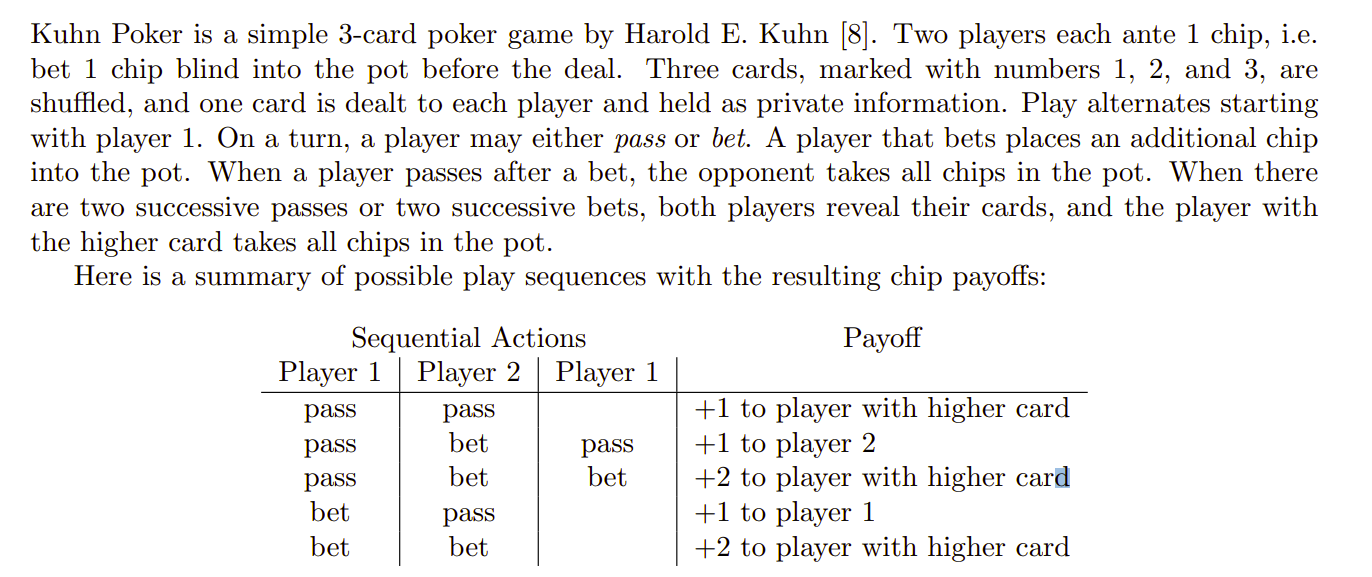

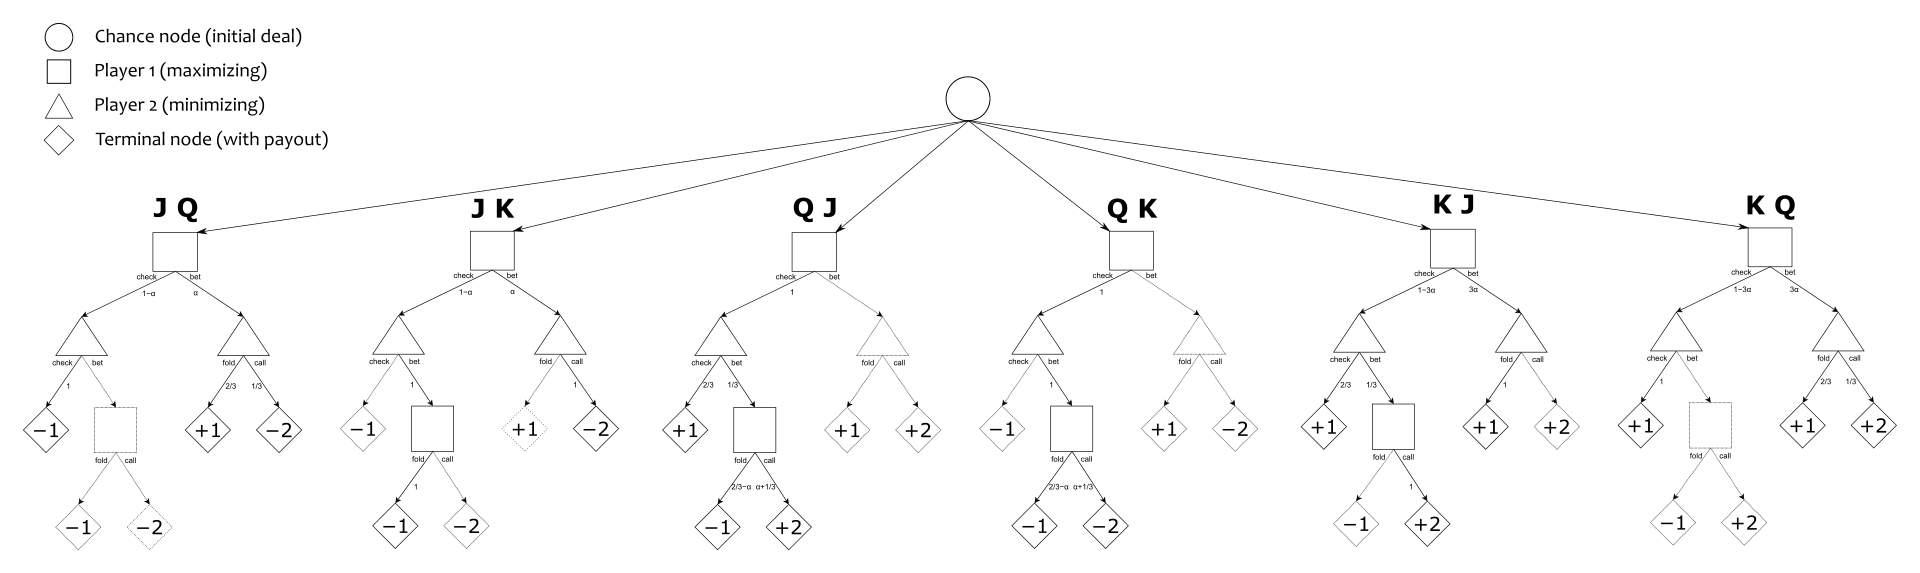

Consider the Kuhn poker game tree with payouts.

In the game tree, there are different states that are indistinguishable to a player. If player 1 has a Q and has seen a pass, we do not know if player 2 has a K or a J. Thus we can group all states that are indistinguishable to a player in an infoset. 

Must find best move given all possible states in an infoset.

In [2]:
# PASS = 0, BET = 1
NUM_ACTIONS = 2

In [3]:
class InfoSet:
    def __init__(self, key : str):
        self.strategySum = np.zeros(NUM_ACTIONS)
        self.regretSum = np.zeros(NUM_ACTIONS)
        self.key = key

    def get_strat(self, discount):
        strategy = [i if i > 0 else 0 for i in self.regretSum]

        if sum(strategy) == 0:
            strategy = np.repeat(1/NUM_ACTIONS, NUM_ACTIONS)
        else:
            strategy = strategy/sum(strategy)

        self.strategySum += strategy*discount

        return strategy
    

    def getAverageStrategy(self):
        avgStrategy = self.strategySum

        if sum(avgStrategy) > 0:
            avgStrategy = avgStrategy/sum(avgStrategy)
        else:
            avgStrategy = np.ones(NUM_ACTIONS)/NUM_ACTIONS
        
        return avgStrategy
    
    def toString(self):
        print(self.key, self.getAverageStrategy())

Using Counter Factual Regret Minmization, the average strategy at each infoset converges. We implement the following algorithm.

Note that 

cf_state_util := $v_i(\sigma, h)$ which is the counterfactual value at infoset I

cf_state_action_util[a] := $v_i(\sigma_{I \rightarrow a}, h)$ which the counterfactual value given that we always pick a at infoset I

In [4]:
class Game:
    def __init__(self):
        self.infoSets = {}
    
    def cfr(self, deck, h : str, p0, p1):
        """
        returns utility of current game state
        """         
        turns = len(h)
        player = turns % 2
        opponent = 1 - player
        player_pr = p0 if player == 0 else p1
        other_pr = p1 if player == 0 else p0

        # Check if history is terminal
        # Either pass pass, bet pass or bet bet
        # Provide the corresponding payouts
        if turns > 1:
            is_terminal_pass = h[turns - 1] == "p"
            is_bet_bet = h[turns - 2 :] == "bb"
            is_player_card_higher = deck[player] > deck[opponent]

            if is_terminal_pass:
                if h == "pp":
                    return 1 if is_player_card_higher else -1
                return 1
            elif is_bet_bet:
                return 2 if is_player_card_higher else -2


        # Get current infoSet which is defined by current player card + history
        info_set_str = str(deck[player]) + h
        info_set = self.infoSets.get(info_set_str)
        if info_set == None:
            info_set = InfoSet(info_set_str)
            self.infoSets[info_set_str] = info_set

        # Recursive forward pass, visit all possible child states 
        cf_state_action_util = np.zeros(NUM_ACTIONS)
        strat = info_set.get_strat(player_pr)

        for i, a in enumerate(["p", "b"]):
            next_hist = h + a
            if player == 0:
                cf_state_action_util[i] = -1*self.cfr(deck, next_hist, strat[i]*p0, p1)
            else:
                cf_state_action_util[i] = -1*self.cfr(deck, next_hist, p0, strat[i]*p1)
        
        cf_state_util =  np.dot(strat, cf_state_action_util)

        #Update regrets
        info_set.regretSum += other_pr*(cf_state_action_util - cf_state_util)

        return cf_state_util
    
    def train(self, epochs):
        deck = [0,1,2]
        util = 0
        for _ in tqdm(range(epochs)):
            rand.shuffle(deck)
            util += self.cfr(deck, "", 1, 1)

        print("Average game value: " + str(util / epochs))
        keys = list(self.infoSets.keys())
        keys.sort()
        for k in keys:
            self.infoSets[k].toString()


In [5]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

game = Game()

game.train(1000000)


  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:32<00:00, 30547.79it/s]

Average game value: -0.056323404357673634
0 [0.7982 0.2018]
0b [1.0000 0.0000]
0p [0.6634 0.3366]
0pb [1.0000 0.0000]
1 [1.0000 0.0000]
1b [0.6624 0.3376]
1p [1.0000 0.0000]
1pb [0.4666 0.5334]
2 [0.3974 0.6026]
2b [0.0000 1.0000]
2p [0.0000 1.0000]
2pb [0.0000 1.0000]


We can see the resulting call, fold probabilities at each infoset. Note that nash equilibrium is achieved when player 1 bets a 0 with prob $\alpha \in [0, \frac13]$ and bet a 2 with prob $3\alpha$